In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os,sys
from collections import defaultdict
from ast import literal_eval

from from_excel_to_list import from_excel_to_list


In [2]:
positions_float_pd=pd.read_csv("../postprocessed-data/genetic_positions_float_pd_all_backgrounds.csv",converters={'Positions_float': literal_eval,'Ninsertions': literal_eval})
positions_float_pd.rename(columns={'Unnamed: 0':'Gene name', "Unnamed: 1": "background"},inplace=True)

discarded_genes_by_duplication=np.loadtxt("../postprocessed-data/discarded_genes_by_duplication.txt",dtype=str)

In [3]:
backgrounds= ['bem1-aid_a','dbem1dbem3_b','wt_merged','dbem1dbem3_a', 
'dnrp1_merged','bem1-aid_b','dbem3_merged']

In [4]:
genes_out_by_neighborhood_pd=pd.read_excel("../postprocessed-data/genes_out_by_neighborhood.xlsx",index_col="Unnamed: 0")
from from_excel_to_list import from_excel_to_list
genes_out_float=defaultdict(dict)
for key in backgrounds:
   genes_out_float["sum upstream insertions"][key] =from_excel_to_list(genes_out_by_neighborhood_pd.loc[key,"sum upstream insertions"])
   genes_out_float["sum downstream insertions"][key] =from_excel_to_list(genes_out_by_neighborhood_pd.loc[key,"sum downstream insertions"])
   x=genes_out_by_neighborhood_pd.loc[key,"discarded_genes_neighborhood"]
   x=x.replace('[', '')
   x=x.replace(']', '')
   x=x.replace('list(', '')
   x=x.replace(')', '')
   x=x.replace("'", "")
   x=x.replace(" ", "")
   x=x.split(',')
   genes_out_float["discarded_genes_neighborhood"][key]=x

genes_out_float_pd=pd.DataFrame.from_dict(genes_out_float)

genes_out_float_pd.loc[:,"threshold coverage"]=genes_out_by_neighborhood_pd.loc[:,"threshold coverage"]

In [5]:
## Importing pergene files 

pergene_files=[]
data_dir="../postprocessed-data/"
#data_dir="../transposonmapper/data_files/"
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith("pergene_insertions.xlsx"):
            pergene_files.append(os.path.join(root, file))

list_data=[]
for i in pergene_files:
    list_data.append(pd.read_excel(i,engine='openpyxl',index_col="Unnamed: 0"))

keys=[]
for i in np.arange(0,len(pergene_files)):
    keys.append(pergene_files[i].split("/")[-1].split("_")[0]+"_"+pergene_files[i].split("/")[-1].split("_")[1])

list_data_pd=pd.concat(list_data,axis=0,keys=keys)

## Strategy for scoring essentiality (Benoit method paper: https://elifesciences.org/articles/23570/figures#fig2s1)

- Compute the longest interval in the gene free of transposons insertions (L)
- Extract the number of insertions for that gene (N)
- Extract the gene length (l)
- Compute the score as:
    score= L*N/(l ^(1.5))
    score == 0 if 
    - N<20
    - L>90 of l 
    - L<10 of l
    - L<300bp

    
  

In [6]:
from functions_scores_essentiality import get_genes_names_for_essentiality

In [7]:
from functions_scores_essentiality import get_essentiality_score_per_gene_per_background

In [8]:
## Loop over all the backgrounds
scores_all=[]
for key in backgrounds:
    useful_genes=get_genes_names_for_essentiality(list_data_pd,genes_out_float_pd,key)
    scores=get_essentiality_score_per_gene_per_background(useful_genes,key,list_data_pd)
    tmp=pd.DataFrame.from_dict(scores)
    scores_all.append(tmp)



In [9]:
scores_all_pd=pd.concat(scores_all,axis=0,keys=backgrounds)

scores_all_pd

value
bem1-aid_a   AAC1   0.092458
             AAC3   0.000000
             AAD10  0.191489
             AAD14  0.181648
             AAD16  0.117475
...                      ...
dbem3_merged ZRT2   0.000000
             ZRT3   0.000000
             ZTA1   0.000000
             ZUO1   0.467329
             ZWF1   0.000000

[43590 rows x 1 columns]

In [10]:
scores_all_pd.to_excel("../postprocessed-data/scores_essentiality_from_Benoit_paper_all_backgrounds.xlsx")

In [11]:
a_wt=scores_all_pd.loc["wt_merged","value"]
a_bem1=scores_all_pd.loc["bem1-aid_a","value"]

In [12]:
predicted_essentials_wt=a_wt[a_wt==0].index
predicted_essentials_bem1=a_bem1[a_bem1==0].index

In [13]:
diff_wt_bem1=np.setdiff1d(predicted_essentials_wt,predicted_essentials_bem1)
diff_bem1_wt=np.setdiff1d(predicted_essentials_bem1,predicted_essentials_wt)

In [14]:
diff_wt_bem1 # essential genes from WT that are not in bem1(conserved essentials)

array(['AAD10', 'AAD3', 'ACS1', 'ADE16', 'ADE4', 'ADH5', 'ADH7', 'ADY2',
       'AGP1', 'AGX1', 'AIM11', 'AIM17', 'AIM2', 'AIM21', 'AIM23',
       'AIM29', 'AIM32', 'AIM34', 'AIM39', 'AKR2', 'ALF1', 'ALG3', 'ALK2',
       'ANB1', 'ANS1', 'APA2', 'ARF1', 'ARG1', 'ARK1', 'ART5', 'ASI3',
       'ASP3-1', 'ASP3-2', 'ASP3-3', 'ASP3-4', 'AST1', 'ATF2', 'ATG15',
       'ATG18', 'ATG3', 'ATG31', 'ATO3', 'ATP23', 'ATS1', 'ATX2', 'AVT1',
       'AYR1', 'BAT2', 'BBC1', 'BDH2', 'BIK1', 'BIM1', 'BIO3', 'BIO4',
       'BLM10', 'BMT5', 'BNA2', 'BNA6', 'BNA7', 'BOR1', 'BPT1', 'BUB2',
       'BUB3', 'BUD13', 'BUD14', 'BUD17', 'BUD25', 'BYE1', 'CAF16',
       'CAJ1', 'CAP1', 'CAP2', 'CAR2', 'CAX4', 'CBF1', 'CCE1', 'CCP1',
       'CDH1', 'CIT1', 'CIT2', 'CIT3', 'CKA2', 'CLB6', 'CLU1', 'CMK1',
       'CMR3', 'CNE1', 'COA1', 'COQ1', 'COQ6', 'COS1', 'COS2', 'COS3',
       'COS4', 'COS5', 'COS6', 'COT1', 'COX3', 'CSF1', 'CSR1', 'CSS2',
       'CTL1', 'CTO1', 'CTP1', 'CTR2', 'CTR3', 'CUE5', 'CUP2', 'CUR1',
  

In [15]:
diff_bem1_wt # essential genes from bem1 that are not in WT (gained essentials)

array(['AAC3', 'AAT2', 'ABF2', 'ACF4', 'ACL4', 'ADE13', 'ADH2', 'ADO1',
       'AGE2', 'AHP1', 'AIM36', 'ALD4', 'ALD5', 'ALG1', 'ALP1', 'ALT1',
       'APQ12', 'ARG82', 'ARL1', 'ARL3', 'ARP1', 'ARP2', 'ARP4', 'ARV1',
       'ASI2', 'ATG12', 'ATG17', 'ATG27', 'ATG32', 'ATG34', 'ATG36',
       'ATG38', 'ATG40', 'ATP1', 'ATP10', 'ATP11', 'ATP12', 'ATP22',
       'ATP5', 'ATP6', 'ATP7', 'BGL2', 'BMH1', 'BMT2', 'BMT6', 'BOS1',
       'BRE5', 'BRR6', 'BSC1', 'BSD2', 'BTT1', 'BUD20', 'BUD21', 'BUD32',
       'BUD5', 'BUR6', 'CAB5', 'CAT5', 'CBP3', 'CBS1', 'CCS1', 'CCW14',
       'CDC10', 'CDC28', 'CDC8', 'CHO1', 'CHZ1', 'CIN4', 'CIR1', 'CKA1',
       'CKB2', 'CKI1', 'CLP1', 'CNB1', 'COA2', 'COG2', 'COG7', 'COQ11',
       'COR1', 'COX26', 'CPD1', 'CPR6', 'CRC1', 'CRG1', 'CRH1', 'CRP1',
       'CSH1', 'CSS1', 'CST9', 'CTK2', 'CTK3', 'CTS1', 'CUE1', 'CWC23',
       'CYS4', 'DAL80', 'DCG1', 'DCN1', 'DDP1', 'DDR48', 'DEP1', 'DGA1',
       'DGK1', 'DIE2', 'DON1', 'DOS2', 'DPB4', 'DSC2', 'DUS1', 'EB

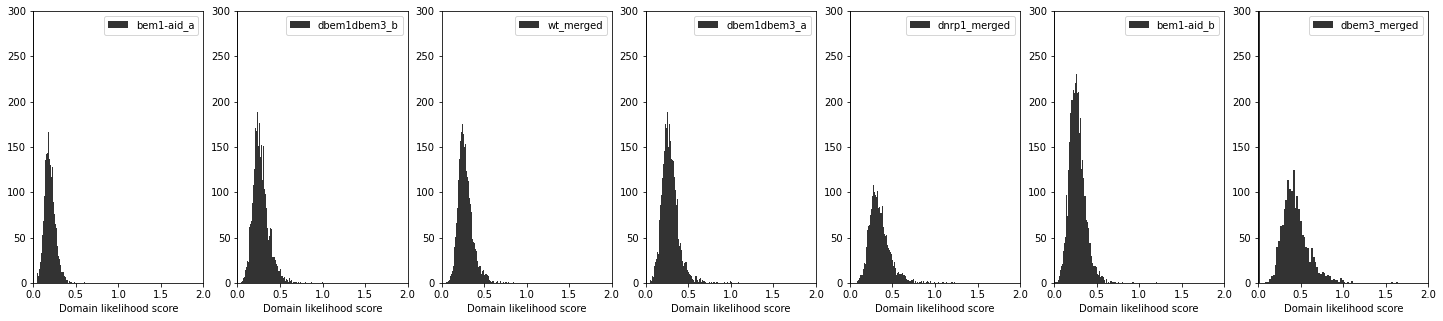

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=len(backgrounds), figsize=(25, 5))
cm = plt.cm.get_cmap('RdYlBu_r')
#color=cm(i/len(backgrounds))
for i in np.arange(0,len(backgrounds)):
    
    ax[i].hist(scores_all_pd.loc[backgrounds[i]]["value"], bins=100, alpha=0.8, label=backgrounds[i], color="black")
    # plt.legend(loc='upper right')
    ax[i].set_xlim([0,2])
    ax[i].set_ylim([0,300])
    ax[i].set_xlabel('Domain likelihood score')


    ax[i].legend(loc='upper right')

fig.savefig("../figures/fig_histogram_domain_likelihood_score_per_background.png",dpi=300)

In [17]:
## Matrix where the rows are the unique genes from the scores and the columns are the backgrounds.
# Fill a 1 if that gene has a score=0 in that background, otherwise fill 0. 

all_genes=[]

for key in backgrounds:
    all_genes.append(scores_all_pd.loc[key]["value"].index)

all_genes_array=np.concatenate( all_genes, axis=0)
all_genes_array_unique=np.unique(all_genes_array)

In [18]:
matrix_differential_score=np.ones((len(all_genes_array_unique),len(backgrounds)))
for k in np.arange(0,len(all_genes_array_unique)):
    for i in np.arange(0,len(backgrounds)):
        if all_genes_array_unique[k] in scores_all_pd.loc[backgrounds[i]]["value"].index:
            if scores_all_pd.loc[backgrounds[i],all_genes_array_unique[k] ]["value"]>0: # if the score is 0, then the gene is not essential
                matrix_differential_score[k,i]=0


<AxesSubplot:>

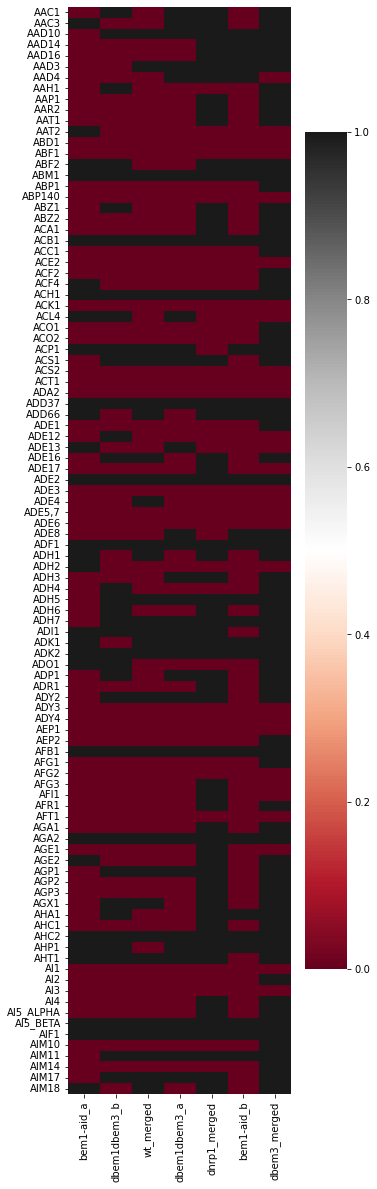

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 20))
n=100
sns.heatmap(matrix_differential_score[0:n,:], xticklabels=backgrounds, yticklabels=all_genes_array_unique[0:n], cmap="RdGy", vmin=0, vmax=1)

#fig.savefig("../figures/fig_prototype_heatmap_domain_likelihood_score_per_background.png",dpi=300)

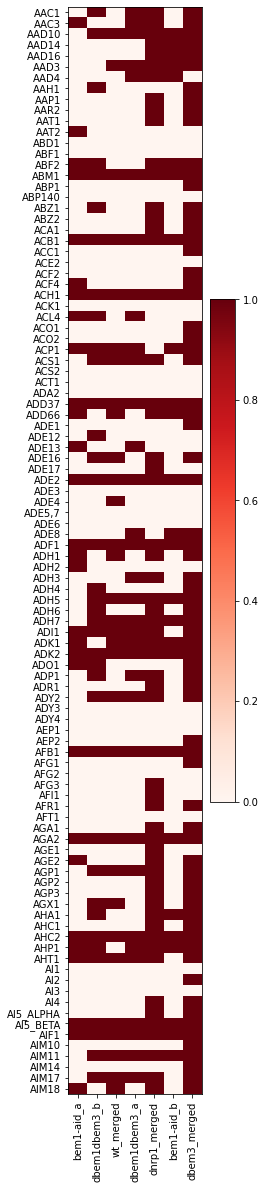

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 20))
plt.imshow(matrix_differential_score[0:n,:], interpolation='nearest', cmap=plt.cm.Reds,aspect='auto')
plt.xticks(range(len(backgrounds)), backgrounds,rotation=90);
plt.yticks(range(n),all_genes_array_unique[0:n]);
plt.colorbar();

#fig.savefig("../figures/fig_prototype_heatmap_domain_likelihood_score_per_background_2.png",dpi=300)

<AxesSubplot:>

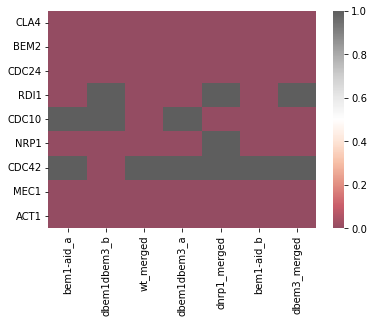

In [21]:
goi=["CLA4","BEM2","CDC24","RDI1","CDC10","NRP1","CDC42","MEC1","ACT1"]
tmp=[]
for i in goi:
    tmp.append(np.where(all_genes_array_unique==i)[0][0])

goi_matrix=matrix_differential_score[tmp,:]
sns.heatmap(goi_matrix, xticklabels=backgrounds, yticklabels=goi, cmap="RdGy", vmin=0, vmax=1,alpha=0.7)


In [22]:
## Validate the  predicted scores for WT with the annotated essential genes for WT

# import true essential genes
true_essentials=pd.read_csv("../postprocessed-data/essentials_genes_yeast.txt",header=None)
true_essentials.columns=["gene_name"]
# compare 


In [23]:
predicted_essentials_wt=scores_all_pd.loc["wt_merged","value"].index

In [24]:
scores_wt=scores_all_pd.loc["wt_merged",:]
for true_genes in true_essentials["gene_name"]:
    if true_genes in scores_wt.index:
        scores_wt.loc[true_genes,"true essential"]=1
    
        

In [25]:
print("The number of predicted essential genes for WT that are also annotated as essential genes is:",
len(scores_wt[(scores_wt["true essential"]==1) & (scores_wt["value"]==0)]),
"which means ",100*len(scores_wt[(scores_wt["true essential"]==1) & (scores_wt["value"]==0)])/len(scores_wt[scores_wt["true essential"]==1]),
"%")

print("The number of predicted essential genes for WT  is:",
len(scores_wt[scores_wt["value"]==0]))

print("The number of annotated essential genes for WT  is:",
len(scores_wt[scores_wt["true essential"]==1]))

The number of predicted essential genes for WT that are also annotated as essential genes is: 279 which means  24.603174603174605 %
The number of predicted essential genes for WT  is: 2768
The number of annotated essential genes for WT  is: 1134
